<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear" data-toc-modified-id="Linear-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение моделей</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод-по-результатам-тестирования" data-toc-modified-id="Вывод-по-результатам-тестирования-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод по результатам тестирования</a></span></li><li><span><a href="#Выводы-по-всей-работе" data-toc-modified-id="Выводы-по-всей-работе-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы по всей работе</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# <center>  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [44]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time
import warnings
from catboost import CatBoostRegressor 
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import make_scorer 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from typing import Any
warnings.filterwarnings('ignore')

In [45]:
# функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()   

In [46]:

try:
    taxis = pd.read_csv('/datasets/taxi.csv',index_col=['datetime'], parse_dates=['datetime'])
except:
    taxis = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=['datetime'], parse_dates=['datetime'])
taxis.sort_index(inplace=True)
taxis = taxis.resample('1H').sum()
taxis.info()
RANDOM_STATE = 42
TEST_SIZE = 0.2

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Вывод ###
- Выполнили загрузку данных,  
в таблице содержится информация о времени и количестве заказов такси на это время
- так как прогноз необходимо выполнить на следующий час, ресемплировали данные с интервалом в 1 час
- для корректного обучения модели выполнили сортировку данных по времени

## Анализ

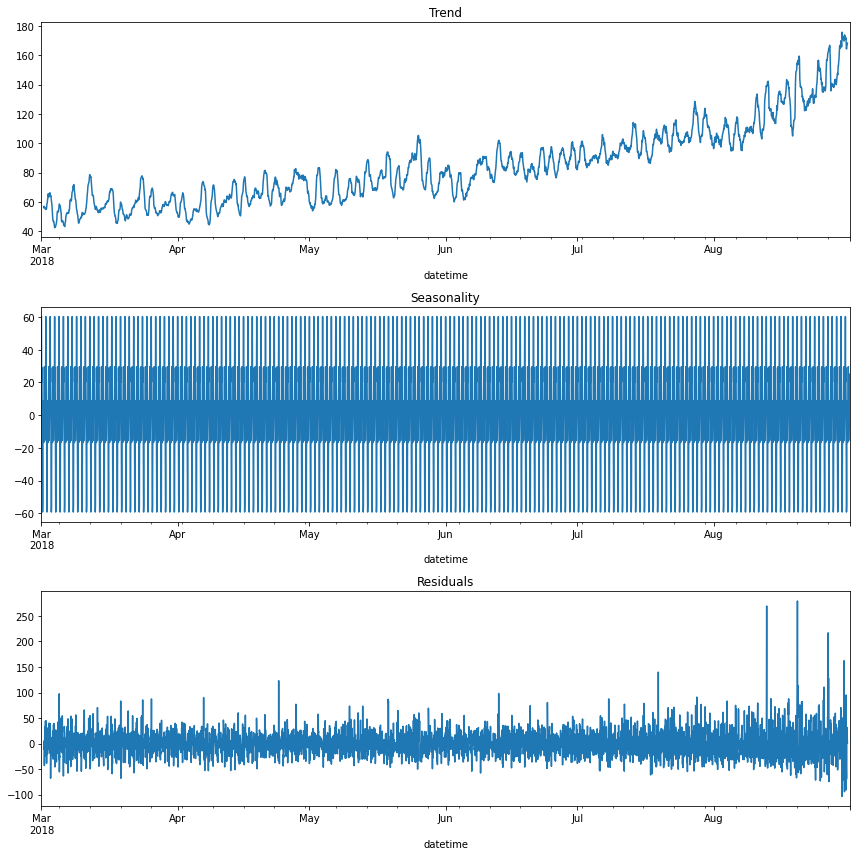

In [47]:
# Анализ временных рядов
decomposed = seasonal_decompose(taxis)
plt.figure(figsize=(12, 12))
plt.subplot(311)
 # тренд
ax=plt.gca()
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
 # сезонная составляющая
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
 # остатки
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:title={'center':'Скользящие средние с окном 24 '}, xlabel='datetime'>

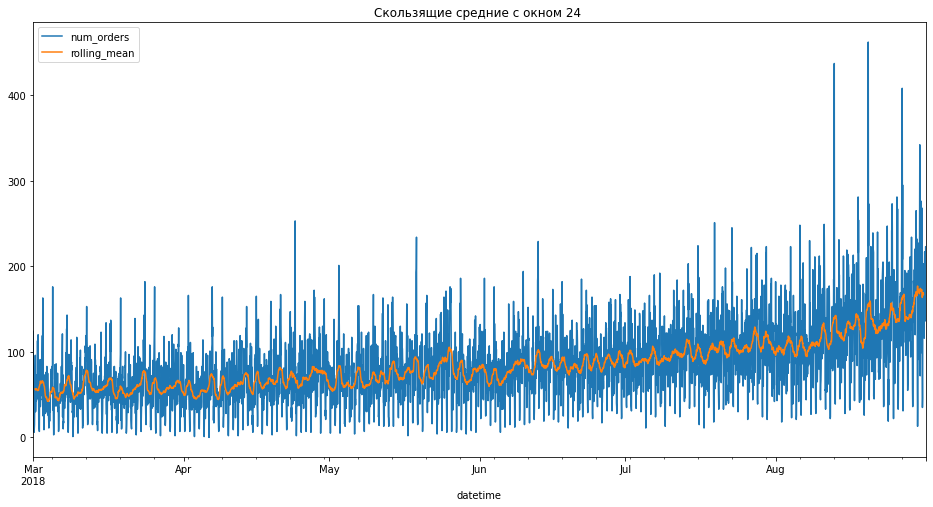

In [48]:
# Рассчитаем скользящие средние
taxis['rolling_mean'] = taxis.rolling(24).mean().shift(-12)
plt.figure(figsize=(16,8))
plt.title("Скользящие средние с окном 24 ")
taxis.plot(ax=plt.gca())

<AxesSubplot:title={'center':'Сезонность заказов в августе'}, xlabel='datetime'>

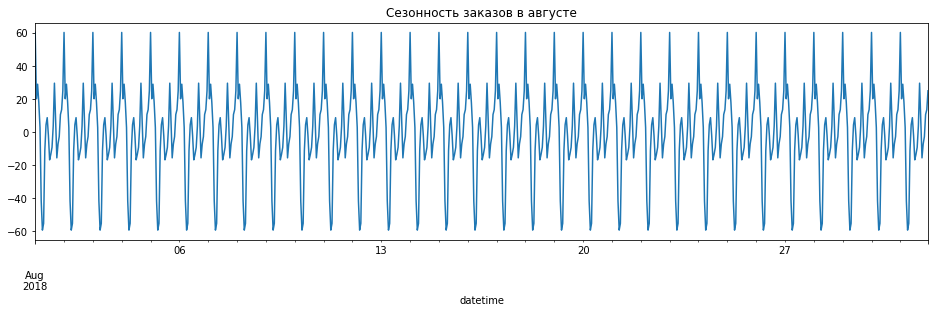

In [49]:
# Рассмотрим сезонность в период равный одному месяцу
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в августе")
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

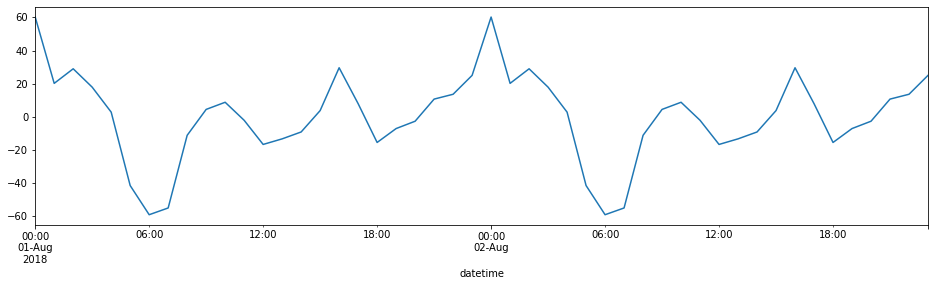

In [50]:
# Рассмотрим сезонность в период 2 дням
plt.figure(figsize=(16,4))
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())

<AxesSubplot:xlabel='datetime'>

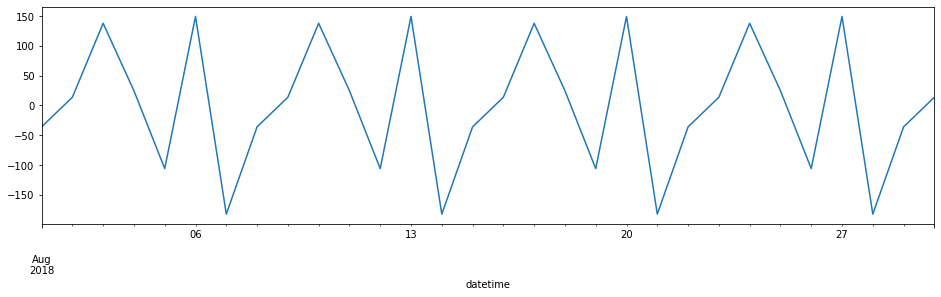

In [51]:
try:
    days_tax = pd.read_csv('/datasets/taxi.csv',index_col=['datetime'], parse_dates=['datetime'])
except:
    days_tax = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=['datetime'], parse_dates=['datetime'])
days_tax.sort_index(inplace=True)
days_tax = days_tax.resample('1D').sum()
decomposed_1 = seasonal_decompose(days_tax)
plt.figure(figsize=(16,4))
decomposed_1.seasonal['2018-08-01':'2018-08-30'].plot(ax=plt.gca())

### Вывод ###
- от **начала года к концу** наблюдается тренд на увеличение заказов
- на графиках видно, что сезонность циклична **по дням**
- в течении дня пиковое колличество заказов в **00:00**
- минимальное количесвто заказов в **6 утра**
- в районе **10, 17** также наблюдается увеличение заказов


## Обучение

In [52]:
# функция для анализа моделей
time_split = TimeSeriesSplit(n_splits=5)

def model_stats(pipeline, parameters, features_train, target_train):
    # Инициализация RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=10, 
        cv=time_split,  
        scoring='neg_root_mean_squared_error',  
        n_jobs=-1,  
        verbose=1, 
        random_state=42  
    )
    random_search.fit(features_train, target_train)
  

    # Время обучения лучшей модели
    best_model = random_search.best_estimator_
    start_time = time.time()
    best_model.fit(features_train, target_train)
    best_training_time = time.time() - start_time

    # Время предсказания лучшей модели
    start_time = time.time()
    predictions = best_model.predict(features_train)
    prediction_time = time.time() - start_time

    # RMSE из кросс-валидации
    rmse = round(-random_search.best_score_, 2)

    # Сбор статистики
    stat_data = [best_training_time, prediction_time, rmse]

    return stat_data, random_search

In [64]:
# добавим признаки для обучения
make_features(taxis, 26, 6)
display(taxis.head(3))

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


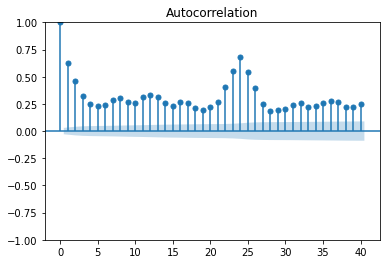

In [62]:

sm.graphics.tsa.plot_acf(taxis.iloc[:, 0].values.squeeze(), lags=40)
plt.show()

In [65]:
train, test = train_test_split(taxis, shuffle=False, test_size=0.1)
train = train.dropna()

print(f'Размер обучающей выборки:{train.shape[0]}')
print(f'Размер тестовой выборки:{test.shape[0]}')


Размер обучающей выборки:3948
Размер тестовой выборки:442


In [66]:
# Определение признаков и целевой переменной для тренировочной выборки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

# Определение признаков и целевой переменной для тестовой выборки
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

### Linear

In [67]:
linear= LinearRegression()
# Сетка гиперпараметров для подбора

pipeline_linear = Pipeline(steps=[
    ('linear', linear)
])
params_linear = {
    'linear__fit_intercept': [True, False]
}


linear_stat, linear_grid = model_stats(pipeline_linear, 
                                       params_linear,
                                      X_train, y_train)


print("Linear Regression - лучшие параметры:", linear_grid.best_params_)
print("Linear Regression - лучшая модель:", linear_grid.best_estimator_)
print("Linear Regression - статистика:", linear_stat)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Linear Regression - лучшие параметры: {'linear__fit_intercept': False}
Linear Regression - лучшая модель: Pipeline(steps=[('linear', LinearRegression(fit_intercept=False))])
Linear Regression - статистика: [0.0889596939086914, 0.00467991828918457, 27.0]


### Random Forest

In [68]:
rforest_model = RandomForestRegressor(random_state=42)

pipeline_rf = Pipeline(steps=[
    ('rf', rforest_model)
])
params_rf = {
    'rf__n_estimators': [80, 120, 240],
    'rf__max_depth': [13, 22, 33],
    'rf__max_features': [3, 6, 9]
}


rf_stat, rf_grid = model_stats(pipeline_rf, 
                                       params_rf,
                                      X_train, y_train)


print("Random Forest - лучшие параметры:", rf_grid.best_params_)
print("Random Forest - лучшая модель:", rf_grid.best_estimator_)
print("Random Forest  - статистика:", rf_stat)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Random Forest - лучшие параметры: {'rf__n_estimators': 240, 'rf__max_features': 9, 'rf__max_depth': 22}
Random Forest - лучшая модель: Pipeline(steps=[('rf',
                 RandomForestRegressor(max_depth=22, max_features=9,
                                       n_estimators=240, random_state=42))])
Random Forest  - статистика: [4.433488130569458, 0.18567562103271484, 24.79]


### DecisionTree

In [70]:
dt_model = DecisionTreeRegressor(random_state=12345)

pipeline_dt = Pipeline(steps=[
    ('dt', dt_model)
])
params_dt = {
    'dt__max_depth': range(4, 7, 1), 
    'dt__min_samples_split': range(26, 29, 1)
}


dt_stat, dt_grid = model_stats(pipeline_dt, 
                                       params_dt,
                                      X_train, y_train)


print("DecisionTree - лучшие параметры:", dt_grid.best_params_)
print("DecisionTree - лучшая модель:", dt_grid.best_estimator_)
print("DecisionTree  - статистика:", dt_stat)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
DecisionTree - лучшие параметры: {'dt__min_samples_split': 27, 'dt__max_depth': 5}
DecisionTree - лучшая модель: Pipeline(steps=[('dt',
                 DecisionTreeRegressor(max_depth=5, min_samples_split=27,
                                       random_state=12345))])
DecisionTree  - статистика: [0.03011345863342285, 0.002240896224975586, 29.76]


### CatBoost

In [71]:
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, silent=True)
params_catboost = {
    'catboost__learning_rate': [0.1],
    'catboost__iterations': [10, 50, 100],
    'catboost__max_depth': [10, 20, 30]
}
pipeline_catboost = Pipeline(steps=[
    ('catboost', catboost_model)
])
catboost_stat, catboost_grid = model_stats(pipeline_catboost, 
                                           params_catboost,
                                           X_train, y_train)
print("CatBoost - лучшие параметры:", catboost_grid.best_params_)
print("CatBoost - лучшая модель:", catboost_grid.best_estimator_)
print("CatBoost - статистика:", catboost_stat)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CatBoost - лучшие параметры: {'catboost__max_depth': 10, 'catboost__learning_rate': 0.1, 'catboost__iterations': 100}
CatBoost - лучшая модель: Pipeline(steps=[('catboost',
                 <catboost.core.CatBoostRegressor object at 0x7fcd29d190d0>)])
CatBoost - статистика: [6.00645112991333, 0.005094766616821289, 25.56]


### LightGBM

In [72]:
# Параметры модели
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = {
    'lgbm__learning_rate': [0.1],
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__max_depth': [10, 20, 30]
}
pipeline_lgbm = Pipeline(steps=[
    ('lgbm', lgbm_model)
])
lgbm_stat, lgbm_grid = model_stats(pipeline_lgbm, 
                                   params_lgbm,
                                   X_train, y_train)

print("LightGBM - лучшие параметры:", lgbm_grid.best_params_)
print("LightGBM - лучшая модель:", lgbm_grid.best_estimator_)
print("LightGBM - статистика:", lgbm_stat)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
LightGBM - лучшие параметры: {'lgbm__n_estimators': 50, 'lgbm__max_depth': 10, 'lgbm__learning_rate': 0.1}
LightGBM - лучшая модель: Pipeline(steps=[('lgbm',
                 LGBMRegressor(max_depth=10, n_estimators=50,
                               random_state=42))])
LightGBM - статистика: [0.7936384677886963, 0.09777235984802246, 24.91]


## Сравнение моделей

In [73]:
stats_data= pd.DataFrame([linear_stat,rf_stat, dt_stat, catboost_stat, lgbm_stat], 
             columns=['Время обучения', 'Время предсказания', 'RMSE'], 
                      index=['LinearRegression','RandomForestRegressor', 'DecisionTreeRegressor', 'CatBoostRegressor', 'LGBMRegressor'])
stats_data

,Время обучения,Время предсказания,RMSE
LinearRegression,0.088960,0.004680,27.00
RandomForestRegressor,4.433488,0.185676,24.79
DecisionTreeRegressor,0.030113,0.002241,29.76
CatBoostRegressor,6.006451,0.005095,25.56
LGBMRegressor,0.793638,0.097772,24.91


### Выводы ###
- обучили 5 моделей, 
- все модели дают премерно одинаковую метрику на обучающей выборке, чуть хуже справилось дерево, лучше всех Random Forest,  
- при этом модель Random Forest дает хороший результат с небольшим временем на обучение

## Тестирование

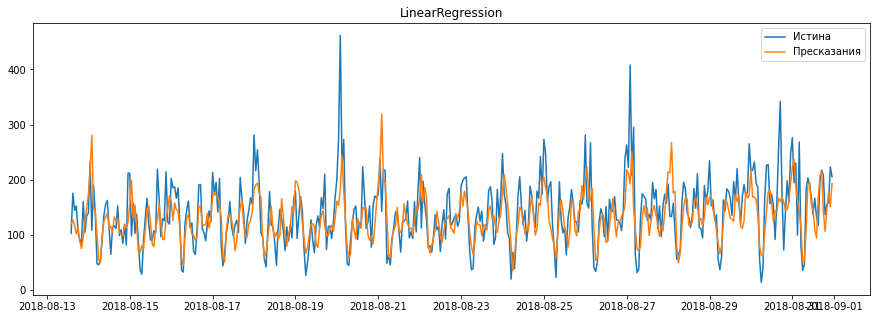

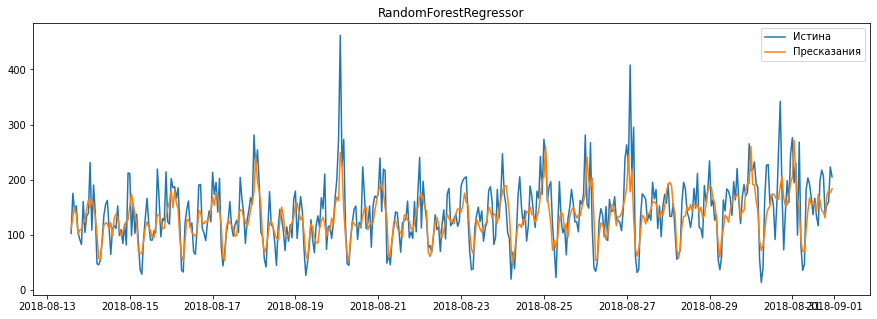

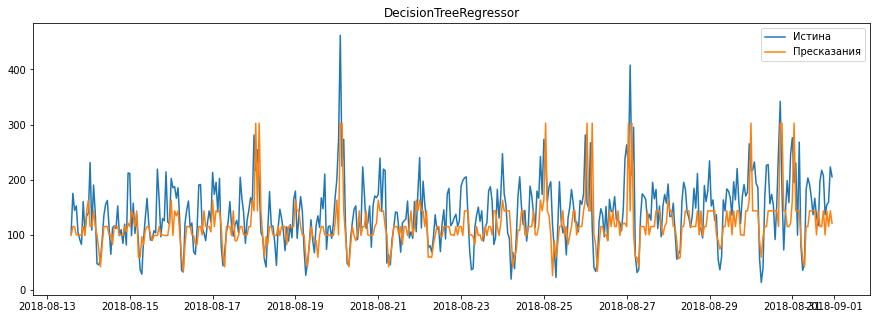

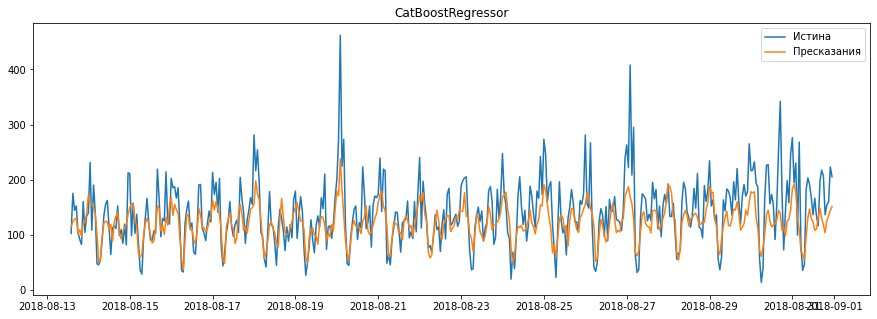

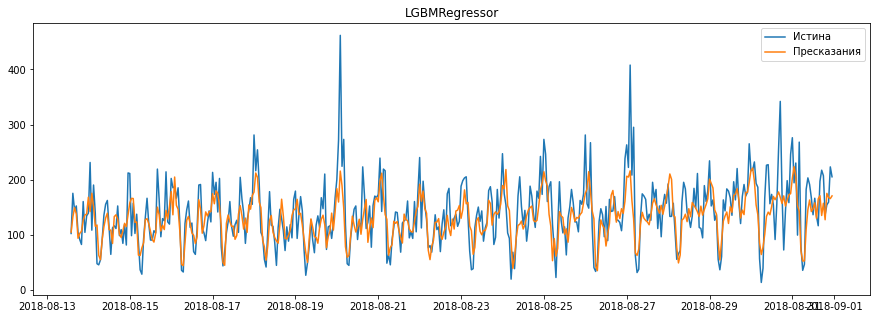

,Время обучения,Время предсказания,RMSE,RMSE на тестовых данных
LinearRegression,0.008203,0.091271,27.02,45.529337
RandomForestRegressor,4.394118,0.198934,25.28,41.954569
DecisionTreeRegressor,0.036216,0.002333,29.69,54.109030
CatBoostRegressor,5.764534,0.003575,25.80,44.895338
LGBMRegressor,0.693925,0.012617,25.52,41.889041


In [18]:
list_params = [linear_grid,rf_grid, dt_grid, catboost_grid, lgbm_grid]
list_name = ['LinearRegression',
             'RandomForestRegressor', 
             'DecisionTreeRegressor', 
             'CatBoostRegressor', 
             'LGBMRegressor']

for i in range(len(list_params)):
    test_predict = list_params[i].predict(X_test)
    test_rmse = (mean_squared_error(y_test, test_predict))**0.5
    stats_data.loc[list_name[i], 'RMSE  на тестовых данных']= test_rmse
    plt.figure(figsize=(15,5))
    plt.plot(y_test, label='Истина')
    plt.plot(y_test.index, test_predict, label='Пресказания')
    plt.title(list_name[i])
    plt.legend();
    plt.show()
stats_data

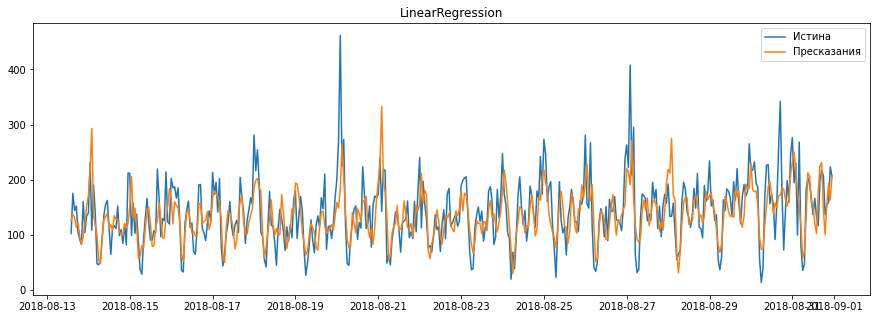

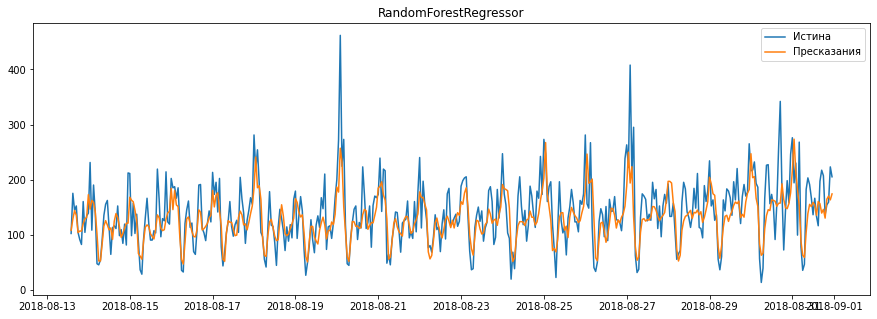

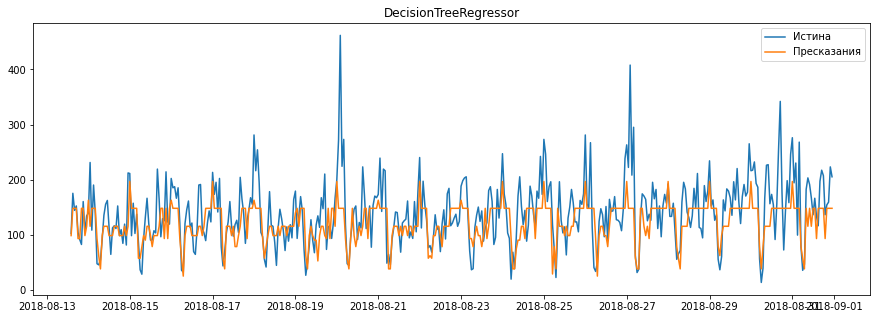

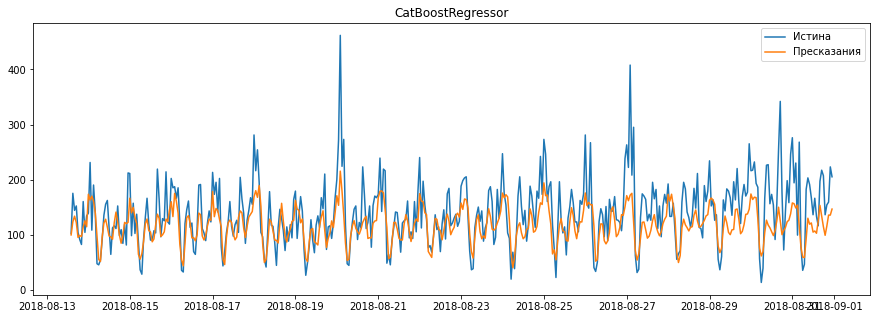

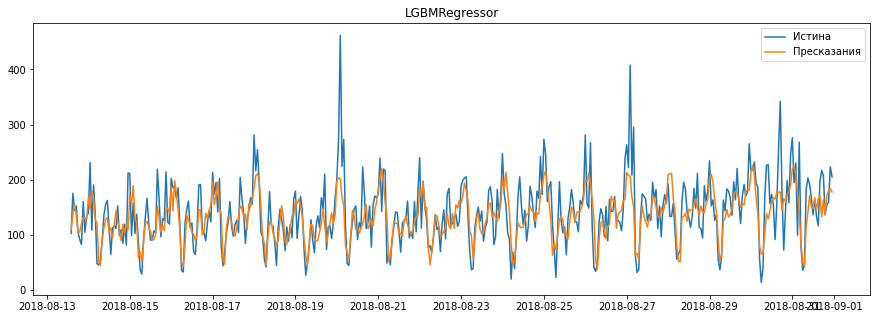

,Время обучения,Время предсказания,RMSE,RMSE на тестовых данных
LinearRegression,0.088960,0.004680,27.00,45.411151
RandomForestRegressor,4.433488,0.185676,24.79,41.430117
DecisionTreeRegressor,0.030113,0.002241,29.76,49.313678
CatBoostRegressor,6.006451,0.005095,25.56,47.053382
LGBMRegressor,0.793638,0.097772,24.91,40.925772


In [74]:
list_params = [linear_grid,rf_grid, dt_grid, catboost_grid, lgbm_grid]
list_name = ['LinearRegression',
             'RandomForestRegressor', 
             'DecisionTreeRegressor', 
             'CatBoostRegressor', 
             'LGBMRegressor']

for i in range(len(list_params)):
    test_predict = list_params[i].predict(X_test)
    test_rmse = (mean_squared_error(y_test, test_predict))**0.5
    stats_data.loc[list_name[i], 'RMSE  на тестовых данных']= test_rmse
    plt.figure(figsize=(15,5))
    plt.plot(y_test, label='Истина')
    plt.plot(y_test.index, test_predict, label='Пресказания')
    plt.title(list_name[i])
    plt.legend();
    plt.show()
stats_data

## Вывод по результатам тестирования

- Как видно в таблице, удалось подобрать параметры для всех моделей кроме дерева решений, для выполнения требований заказчика по метрике на тестовой выборке  меньше 48
- Оптимальная модель с лучшим соотношением время обучение и качество - LGBMRegressor, которую рекомендуем заказчику

## Выводы по всей работе

В рамках работы была загружена таблица с данными о времени и количестве заказов в службе такси
- выполнили **сортировку** данных
- ресемплировлаи данные в рамках **одного часа**

Анализ показал, 
- что сезонность в данных наблюдается **ежедневная**, 
- Также выявили тренд на увеличение заказов в **течении года**
- для сглаживания шума посчитали скользящие средние

Обучение:
- написали функцию для подбора параметров и сравнения разных моделей
- создали дополнительные признаки для лучшего обучения модели
- выполнили обучение **5** различных моделей
- все модели дают премерно одинаковую метрику на обучающей выборке, чуть хуже справилось дерево, чуть лучше **Random Forest**,  
- при этом модель **LGBMRegressor** дает хороший результат с небольшим временем на обучение

Тестирование:
- при тестировании выяснили какие модели подходят для получения необходимого результата 
- рекомендуем использовать модель -   **LGBMRegressor** - так как эта модель дает оченьь хороший результат и довольно быстро обучается
